## Time Series Problems using LSTMs

### Practical Introduction to Deep Learning - AIMS 2019

***Dr. Emmanuel Dufourq*** www.emmanueldufourq.com

***African Institute for Mathematical Sciences***

***Stellenbosch University***

***2019***




In [ ]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

%matplotlib inline

%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

1.15.0


In [ ]:
print (tf.__version__)

1.15.0


## load dataset

In [ ]:
dataset = pd.read_csv('https://drive.google.com/uc?export=download&id=14ClWfLdHNzxwCzbWKVhWLG074dK85h3y', header=0, index_col=0)
values = dataset.values

In [ ]:
dataset

pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0
...                        ...  ...   ...     ...     ...      ...   ...   ...
2014-12-31 19:00:00        8.0  -23  -2.0  1034.0      NW   231.97     0     0
2014-12-31 20:00:00       10.0  -22  -3.0  1034.0      NW   237.78     0     0
2014-12-31 21:00:00       10.0  -22  -3.0  1034.0      NW   242.70     0     0
2014-12-31 22:00:00        8.0  -22  -4.0  1034.0      NW   246.72     0     0
2014-12-31 23:00:00       12.0  -21  -3.0  1034.0      NW   249.85     0     0

[43800 rows x 8 columns]

## Plot pollution

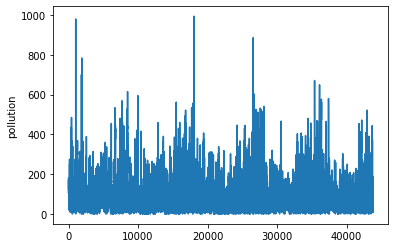

In [ ]:
plt.plot(values[:,0])
plt.ylabel(dataset.columns[0])
plt.show()

## Plot dew

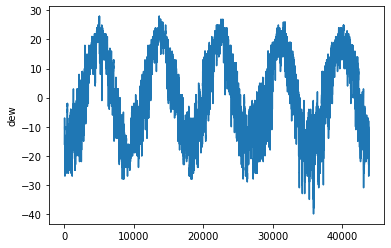

In [ ]:
plt.plot(values[:,1])
plt.ylabel(dataset.columns[1])
plt.show()

## Plot temp

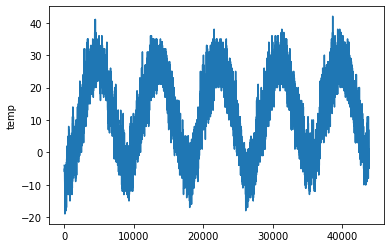

In [ ]:
plt.plot(values[:,2])
plt.ylabel(dataset.columns[2])
plt.show()

## Plot press

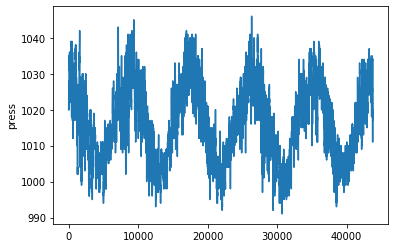

In [ ]:
plt.plot(values[:,3])
plt.ylabel(dataset.columns[3])
plt.show()

## Plot wnd_spd

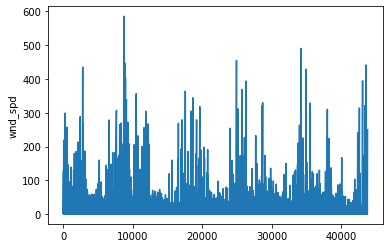

In [ ]:
plt.plot(values[:,5])
plt.ylabel(dataset.columns[5])
plt.show()

## Plot snow

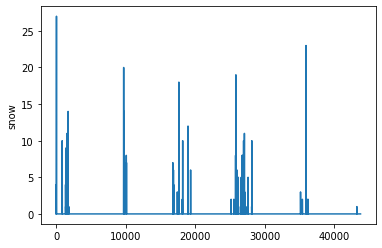

In [ ]:
plt.plot(values[:,6])
plt.ylabel(dataset.columns[6])
plt.show()

## Data preparation

We need a way to prepare the data for whatever way we would like to formulate the problem.

In this case we are formulating it such that we take in 1 time step input (8 variables) and output 1 time step output (1 variable). In other words we are trying to solve the following question: given the pollution and weather conditions of the previous hour, can we predict the pollution level for the next hour.

The single variable we are outputing is the pollution level. Note we also use pollution level in our input.

Credit for this code: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Get column names

In [ ]:
dataset.columns

Index(['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow',
       'rain'],
      dtype='object')

## Actually perform the data preparation

Here we encode the 4th variable as it is categorical.

We scale the values between 0 and 1.

The code which converts the data into the suitable way we want, in this case, will produce 8 output variables. In our case we only want to predict pollution, that is why we drop the other collumns from the dataframe.

Credit for this code: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [ ]:
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
# We drop these because we are only interested in predicting for a single variable (pollution).
# If we don't drop, then we will be predicting for all the variables too!
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
values = reframed.values

## View the data

In [ ]:
reframed.head()

var1(t-1)  var2(t-1)  var3(t-1)  ...  var7(t-1)  var8(t-1)   var1(t)
1   0.129779   0.352941   0.245902  ...   0.000000        0.0  0.148893
2   0.148893   0.367647   0.245902  ...   0.000000        0.0  0.159960
3   0.159960   0.426471   0.229508  ...   0.000000        0.0  0.182093
4   0.182093   0.485294   0.229508  ...   0.037037        0.0  0.138833
5   0.138833   0.485294   0.229508  ...   0.074074        0.0  0.109658

[5 rows x 9 columns]

## Create X and Y variables

In [ ]:
values.shape

(43799, 9)

In [ ]:
X = values[:,:-1]

In [ ]:
Y = values[:,-1]

## Check the shapes

In [ ]:
X.shape

(43799, 8)

In [ ]:
Y.shape

(43799,)

## Reshaping

The format that Keras expects is [batches, timesteps, features]

In [ ]:
X = X.reshape(X.shape[0],1,X.shape[1])

In [ ]:
X.shape

(43799, 1, 8)

## Training, validation and testing split

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.20, random_state=42)

## Check the shape

In [ ]:
print ('X_train:',X_train.shape)
print ('Y_train:',Y_train.shape)
print ()
print ('X_val:',X_val.shape)
print ('Y_val:',Y_val.shape)
print ()
print ('X_test:',X_test.shape)
print ('Y_test:',Y_test.shape)

X_train: (28031, 1, 8)
Y_train: (28031,)

X_val: (7008, 1, 8)
Y_val: (7008,)

X_test: (8760, 1, 8)
Y_test: (8760,)


## Define a model

In [ ]:
model = Sequential()
model.add(LSTM(16, input_shape=(1, 8)))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss='mae', optimizer='adam')

## Print summary

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 16)                1600      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,617
Trainable params: 1,617
Non-trainable params: 0
_________________________________________________________________


## Training

In [ ]:
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=5, batch_size=8, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 28031 samples, validate on 7008 samples
Epoch 1/5





28031/28031 [==============================] - 10s 344us/step - loss: 0.0501 - val_loss: 0.0201
Epoch 2/5
28031/28031 [==============================] - 8s 291us/step - loss: 0.0189 - val_loss: 0.0172
Epoch 3/5
28031/28031 [==============================] - 8s 289us/step - loss: 0.0174 - val_loss: 0.0164
Epoch 4/5
28031/28031 [==============================] - 8s 292us/step - loss: 0.0167 - val_loss: 0.0156
Epoch 5/5
28031/28031 [==============================] - 8s 302us/step - loss: 0.0164 - val_loss: 0.0162


## Plot the performance

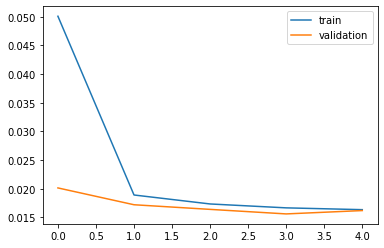

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

## Predict

In [ ]:
prediction = model.predict(X_test)

In [ ]:
mean_squared_error(Y_test, prediction)

0.00089074083

## Compare prediction and testing data

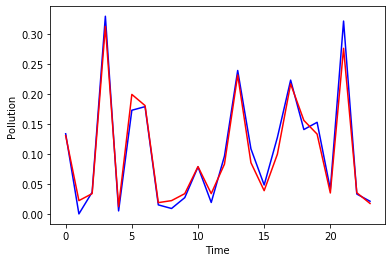

In [ ]:
plt.plot(Y_test[0:24], color='blue')
plt.plot(prediction[0:24], color='red')
plt.ylabel('Pollution')
plt.xlabel('Time')
plt.show()

## Task:

- Modify the code such that instead of using 1 time step and 8 features as input, use 2 time steps and 8 features as input. You will need to make a number of modifications, but primarily when calling series_to_supervised as it currently has values 1 and 1.
- Modify the code such that the model architecture is as follows: LSTM layer followed by LSTM layer followed by Dense layer. A LSTM expects a 3D input, so you need to modify the first LSTM to return a 3D output. This can be ahieved by returning the sequences (which returns a value for each time step in the layer). Find out more on the Keras documentation.
- Modify the network such that it does not have a fully connected layer as output.